# Neural Networks
## Lab session 4: tf.data & convolutional neural networks

In [0]:
# Remember to enable GPU in the runtime before running the code!

In [0]:
# Import TensorFlow and enable eager execution
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

In [0]:
# Import NumPy
import numpy as np

In [0]:
# Download MNIST dataset (try also Fashion MNIST!)
(Xtrain, ytrain), (Xtest, ytest) = tf.keras.datasets.mnist.load_data()

In [0]:
# Cast targets to np.int32
ytrain = ytrain.astype(np.int32)
ytest = ytest.astype(np.int32)

In [0]:
# Example of tf.data
train_it = tf.data.Dataset.from_tensor_slices((Xtrain, ytrain))
test_it = tf.data.Dataset.from_tensor_slices((Xtest, ytest))

In [0]:
# Get a single image
for xb, yb in train_it.batch(1):
  break;

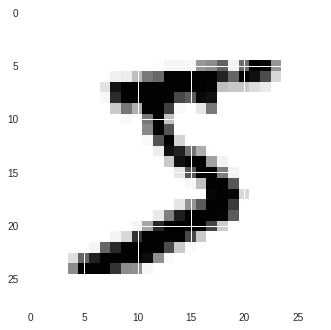

In [8]:
# Show the image
import matplotlib.pyplot as plt
plt.imshow(xb[0])
plt.show()

In [9]:
# Check shape and label
print(xb.shape)
print(yb)

(1, 28, 28)
tf.Tensor([5], shape=(1,), dtype=int32)


In [0]:
# Definitely not the most efficient way!
def _parse_example(x, y):
  x = tf.cast(tf.reshape(x, (28, 28, 1)), tf.float32) / tf.constant(255.0)
  return x, y

In [0]:
# Map all examples with the function
# Check documentation of Dataset.map here: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map
train_it = train_it.map(_parse_example)
test_it = test_it.map(_parse_example)

In [0]:
# Architecture is taken from here: https://www.tensorflow.org/tutorials/estimators/cnn#building_the_cnn_mnist_classifier

class CNN(tf.keras.Model):
  
  def __init__(self):
    super(CNN, self).__init__()
    
    self.conv1 = tf.layers.Conv2D(filters=32, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
    self.pool1 = tf.layers.MaxPooling2D(pool_size=[2, 2], strides=2)
    
    
    self.conv2 = tf.layers.Conv2D(filters=64, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
    self.pool2 = tf.layers.MaxPooling2D(pool_size=[2, 2], strides=2)


    self.dense = tf.layers.Dense(1024, activation=tf.nn.relu)
    self.dropout = tf.layers.Dropout(0.4)
    
    self.logits = tf.layers.Dense(units=10)
    
  def call(self, x, training=False):
    
    x = self.pool1(self.conv1(x))
    x = self.pool2(self.conv2(x))
    x = self.dense(tf.reshape(x, (-1, 7 * 7 * 64)))
    x = self.dropout(x, training=training)
    return self.logits(x)

In [0]:
# Initialize
cnn = CNN()

In [14]:
for xb, yb in train_it.batch(1):
  print(cnn(xb))
  break;

tf.Tensor(
[[-0.00517298 -0.04869059  0.12427396 -0.01968962  0.04045241  0.08706979
  -0.11381523  0.03049949  0.02493023  0.03556203]], shape=(1, 10), dtype=float32)


In [0]:
def loss(net, x, y):
  return tf.losses.sparse_softmax_cross_entropy(logits=net(x, training=True), labels=y)

In [0]:
opt = tf.train.AdamOptimizer()
epochs = 10

In [20]:
all_acc = np.zeros(epochs)

for epoch in range(epochs):
  
  acc = tfe.metrics.SparseAccuracy()
  for xb, yb in test_it.batch(32):
    ypred = cnn(xb)
    acc(predictions=ypred, labels=yb)
  all_acc[epoch] = acc.result().numpy()
  print('Test accuracy at epoch {} is {} %'.format(epoch, all_acc[epoch] * 100))
  
  for xb, yb in train_it.shuffle(1000).batch(32):
    opt.minimize(lambda: loss(cnn, xb, yb))

Test accuracy at epoch 0 is 9.82 %
Test accuracy at epoch 1 is 98.76 %
Test accuracy at epoch 2 is 98.95 %
Test accuracy at epoch 3 is 98.65 %
Test accuracy at epoch 4 is 99.2 %
Test accuracy at epoch 5 is 98.96000000000001 %
Test accuracy at epoch 6 is 98.49 %
Test accuracy at epoch 7 is 99.03 %
Test accuracy at epoch 8 is 99.0 %
Test accuracy at epoch 9 is 99.11 %


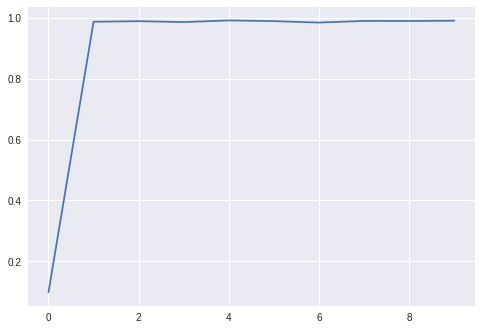

In [21]:
plt.plot(all_acc)